# Phabricator code reviewers

Trends and statistics for Firefox code reviews using the Phabricator code review system.

In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns

sns.set_style("dark")

Our dataset is the list of transactions that took place on each phabricator revision of the Firefox repository. 

In [2]:
datafile = Path.cwd() / ".." / "data" / "processed" / "transactions.parq"
df = pd.read_parquet(str(datafile))

Make our columns a bit easier to understand.

In [3]:
df = df.rename(columns={"objectPHID": "revision"})

Extract the list of revision IDs.

In [4]:
revisions = pd.DataFrame({"revision": df["revision"].unique()})
revisions.count()

revision    16924
dtype: int64

Extract the transactions that open and close transactions.

In [5]:
opens = df[df["type"] == "create"][["revision", "dateCreated"]]
print("Revisions opened over this time period:", len(opens))

closes = df[df["type"] == "close"][["revision", "dateCreated"]]
print("Revisions closed over this time period:", len(closes))

Revisions opened over this time period: 16772
Revisions closed over this time period: 15243


Combine the transactions into single rows per revision.

In [6]:
revisions = pd.merge(revisions, opens, on="revision")

# Change the column name so it makes sense in the merged dataframe
closes = closes.rename(columns={"dateCreated": "dateClosed"})
revisions = pd.merge(revisions, closes, on="revision")

## How many reviews are performed per-reviewer?

How many reviewers accepted revisions?

In [7]:
reviews = df[df["type"] == "accept"][["revision", "authorPHID", "dateCreated"]]
reviews = reviews.rename(columns={
    "authorPHID": "reviewer",
    "dateCreate": "dateReviewed",
})
reviews["reviewer"].nunique()

336

In [8]:
byreviewer = reviews.groupby("reviewer")

In [9]:
review_count_by_reviewer = byreviewer.size()

Are there any reviewers that look to be helper bots because of an abnormal number of reviews?

In [10]:
review_count_by_reviewer.nlargest()

reviewer
PHID-USER-mwithgebwtz2ytyehnps    453
PHID-USER-sj37bt54oolbdxrxiirg    450
PHID-USER-7hxjutcooeszod3rg3dr    427
PHID-USER-ppexvnh4ahku2ypgjpmd    326
PHID-USER-7kwqcpqrdv7xuk47hcvc    324
dtype: int64

The number of reviews per-reviewer slopes down gradually and the largest number of reviews is only a fraction of the total reviews so they are probably all real users.

What does the distribution of the number of reviews performed across all reviewers look like?

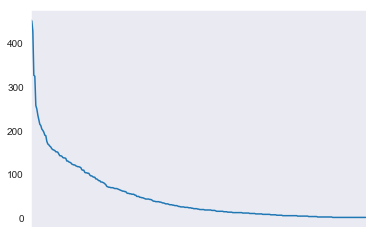

In [11]:
ax = review_count_by_reviewer.sort_values(ascending=False).plot()
ax.get_xaxis().set_visible(False)

In [12]:
review_count_by_reviewer.describe()

count    336.000000
mean      49.592262
std       69.053886
min        1.000000
25%        5.750000
50%       20.000000
75%       67.250000
max      453.000000
dtype: float64

## What is the median time for a reviewer to first review code?

In [13]:
# Make sure we take business days/weekends into account!
def bday_duration(x):
    """Duration in business days."""
    opened = x["dateCreated"]
    closed = x["dateClosed"]
    duration = closed - opened
    if duration.days < 2:
        # We could have closed or opened on a weekend.
        return duration
    
    if closed.weekday() < opened.weekday():
        # Falls over a weekend.  Subtract 2 calendar days.
        offset = pd.offsets.Day(-2)
    else:
        offset = pd.offsets.Day(0)
    return duration + offset


What kinds of transactions do we have to consider?

In [14]:
df["type"].value_counts()

update             53160
inline             38278
comment            35185
status             20644
title              19075
create             16772
accept             16663
request-review     16632
close              15243
request-changes     3479
abandon             1828
reopen              1608
plan-changes         369
resign               292
commandeer           234
reclaim               34
Name: type, dtype: int64

Find the transactions where a reviewer interacted with a code review.

In [15]:
interaction_types = ("accept", "request-changes", "resign")
interactions = df[df["type"].isin(interaction_types)].rename(
    columns={
        "authorPHID": "reviewer",
        "dateCreated": "dateReviewed",
    }
)
print("Total times reviewers interacted with code reviews:", len(interactions))

Total times reviewers interacted with code reviews: 20434


We only want to measure the time a review spent in the "Needs Review" state.  That state could be interrupted by (potentially long) periods of the review sitting in the "Planned Changes" state.  To simplify the calculation of the time spent waiting for review we can exlude all reviews that spent time in "Planned Changes".

In [16]:
changes_planned = df[df["type"] == "plan-changes"]
print("Reviews with changes planned:", changes_planned["revision"].nunique())

Reviews with changes planned: 304


In [17]:
changes_planned_rev_array = changes_planned["revision"].unique()

Dump the "Planned Changes" transactions.

In [18]:
interactions = interactions.set_index("revision").drop(changes_planned_rev_array, errors="ignore")

Sort all of the interactions by date.  Then Group all interactions by reviewer and then by revision, creating (reviewer, revision) pairs for each interaction.

Keep just the first interaction from each (reviewer, review) interaction pair, which corresponds to the first time the reviewer X worked with revision Y.

In [19]:
first_review = interactions.sort_values(by="dateReviewed").groupby(["reviewer", "revision"], sort=False).first()

Merge in the time that the revisions were first created.

In [20]:
opens = df[df["type"] == "create"][["revision", "dateCreated"]].rename(
    columns={"dateCreated": "dateRevisionCreated"}
)
reviews = pd.merge(first_review.reset_index(), opens, on="revision")
reviews.shape

(16312, 8)

When calculating the time from revision creation until a review is performed we want to calculate *business days*, not calendar days.

In [21]:
from businessdays import bday_duration

reviews["duration"] = reviews.apply(
    lambda x: bday_duration(x["dateRevisionCreated"], x["dateReviewed"]),
    axis="columns",
)

Group by reviewer and find the median time to review.

In [27]:
hours_to_review = reviews.set_index("reviewer")["duration"].dt.total_seconds() / 3600
grouped_reviews = hours_to_review.groupby("reviewer")
reviewer_stats = pd.DataFrame({"median_hours_to_review": grouped_reviews.median(), "review_count": grouped_reviews.size()})
reviewer_stats.sort_values("review_count", ascending=False).head(50).reset_index(drop=True)

,median_hours_to_review,review_count
0,14.470556,461
1,0.092361,450
2,11.534167,416
3,15.834444,317
4,14.165417,312
5,9.161111,257
6,12.953333,251
7,2.780556,238
8,19.517500,207
9,24.237639,204
